Install Box2D: `pip install "gymnasium[box2d]"`
To play with the car racing game: `python env/lib/python3.9/site-packages/gymnasium/envs/box2d/car_racing.py`

In continuous space, there are 3 actions:
* 0: steering, -1 is full left, +1 is full right
* 1: gas
* 2: breaking

In discrete space there are 5 actions:
* 0: do nothing
* 1: steer left
* 2: steer right
* 3: gas
* 4: brake

Observation space: a top-down 96x96 RGB image of the car and race track.

The reward is -0.1 every frame and +1000/N for every track tile visited, where N is the total number of tiles visited in the track. For example, if you have finished in 732 frames, the total reward is 1000 - 0.1*732 = 926.8 points.

The episode finishes when all the tiles are visited. The car can also go outside the playfield - that is, far off the track, in which case it will receive -100 reward and die.

In [1]:
import torch
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    print("Using MPS")
    mps_device = torch.device("mps")


Using MPS


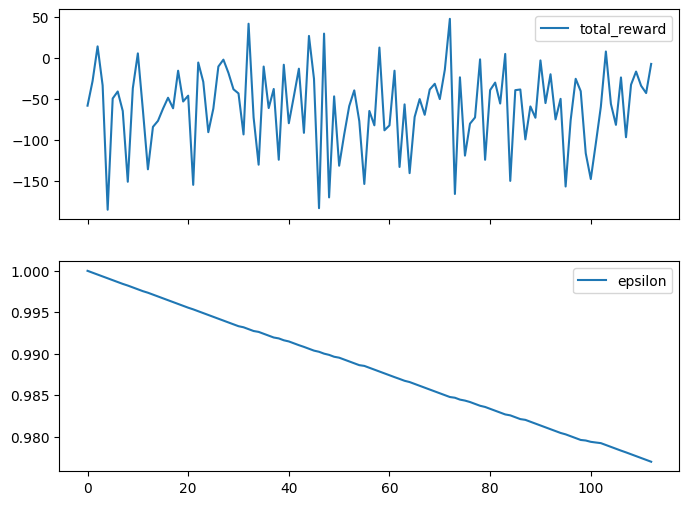

KeyboardInterrupt: 

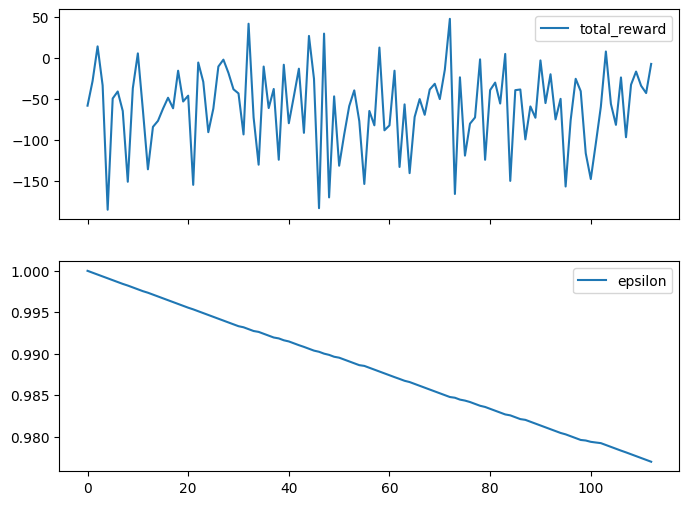

In [11]:
from IPython.display import display, clear_output

import random
import numpy as np
import pickle
from collections import deque
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
import gymnasium as gym
import torch

from deep_q_network import DQN

# domain_randomize: background and track colours are different on every reset.
env = gym.make("CarRacing-v3", domain_randomize=False, continuous=True)

# state size = 16*16 img *4 frames = 1024 bytes
# 100 MB buffer size = 100 000 states
# buffer has to be large enough to break correlations between multiple states
buffer_size = int(10000)  # 1e6 in the paper
buffer = deque(maxlen=buffer_size)  # will automatically pop items when we go over the buffer_size
buffer_pbar = tqdm(total=buffer_size)  # progress bar to keep track of buffer filling up.

frame_stack_len = 3
skip_frames = 4

# atari paper
# "epsilon annealed linearly from 1 to 0.1 over the first million
# frames, and fixed at 0.1 thereafter"
epsilon_start = 1
epsilon_min = 0.1
epsilon_decay = 0.9999 # np.exp(np.log(epsilon_min/epsilon)/60000)  # such that epsilon * epsilon_decay ** 60k steps = epsilon_min
def get_epsilon(frame: int):
    n_frames = 1e6
    global epsilon
    if frame >= n_frames:
        return epsilon_min
    else:
        return (epsilon_min - epsilon_start) / (n_frames - 1) * (frame - 1) + epsilon_start

batch_size = 32
gamma = 0.95

model = DQN(frame_stack_len=3, learning_rate=1e-3)
model.to(mps_device)
target_model = DQN()
target_model.to(mps_device)
tensorboard = False

def sync_models(model, target_model, path="./checkpoints/dqn.pt"):
    torch.save(model.state_dict(), path)
    target_model.load_state_dict(torch.load(path, map_location=mps_device))

sync_models(model, target_model)

if tensorboard:
    writer = SummaryWriter()
else:  # use matplotlib in interactive mode.
    metrics = {
        "total_reward": [],
        "epsilon": [],
    }
    
    plt.ion()  # Turn on interactive mode
    fig, ax = plt.subplots(len(metrics), 1, sharex=True, figsize=(8, 6))
    # Initialize line object and legend

    lines = dict()
    for i, k in enumerate(metrics.keys()):
        lines[k], = ax[i].plot([], [], label=k)
        ax[i].legend(loc="upper right")

# n_episodes = 100
n_updates = 200000  # 10M frames in the paper
pbar = tqdm(total=n_updates)
updates_counter = 0
episode_counter = 0
best_total_reward = 0
sync_models_frequency = 5  # episodes

while updates_counter < n_updates:
    episode_counter += 1
    # normal reset changes the colour scheme by default
    obs, info = env.reset()
    s = model.preprocess(obs)
    frame_stack = deque(maxlen=frame_stack_len)
    frame_stack.extend([s for _ in range(frame_stack_len)])  # init with the same state.
    done = False
    t = 1
    total_loss = 0
    total_reward = 0
    negative_reward_counter = 0
    time_frame_counter = 1
    while not done:  # sample one episode.
        state = torch.concatenate(list(frame_stack), dim=0)
        state = state.unsqueeze(0).to(mps_device)  # add batch dim
        epsilon = get_epsilon(frame=updates_counter)
        a = model.act(epsilon, state)  # action index
        a_arr = model.action_space[a]  # tuple (steering, gas, break)
        reward = 0
        # repeat same action over skip_frames
        for _ in range(skip_frames):
            t += 1
            new_obs, r, terminated, truncated, info = env.step(a_arr)
            reward += r

            new_s = model.preprocess(new_obs)
            frame_stack.append(new_s)

            done = terminated or truncated # truncated ?
            if done:
                break
            
        # if time_frame_counter > 100 and reward < 0:
        #     negative_reward_counter += 1
        # else:
        #     negative_reward_counter = 0
        
        # Extra bonus for the model if it uses full gas
        if a_arr[1] == 1 and a_arr[2] == 0:
            reward *= 1.5

        total_reward += reward
        
        new_state = torch.concatenate(list(frame_stack), dim=0)
        new_state = new_state.unsqueeze(0)
        
        buffer.append((state, a, reward, new_state, done))
        # no need to wait for full buffer to start training. 

        time_frame_counter += 1

        # early termination of negative episodes. 
        # This helps training, probably because the agent can play more episodes this way.
        # if done or negative_reward_counter >= 25 or total_reward < 0:
        #     break

        # construct batch.
        batch = {"r": [], "done": [], "s": [], "new_s": [], "a": []}
        # replacement ?
        batch_indices = np.random.randint(0, len(buffer), size=batch_size)
        for batch_index in batch_indices:
            sj, aj, rj, new_sj, donej = buffer[batch_index]
            batch["done"].append(float(donej))
            batch["r"].append(rj)
            batch["s"].append(sj)
            batch["new_s"].append(new_sj)
            batch["a"].append(aj)

        batch["done"] = torch.tensor(batch["done"], device=mps_device)
        batch["r"] = torch.tensor(batch["r"], device=mps_device)
        batch["s"] = torch.concatenate(batch["s"], dim=0).to(mps_device)
        batch["new_s"] = torch.concatenate(batch["new_s"], dim=0).to(mps_device)
        batch["a"] = torch.tensor(batch["a"], dtype=torch.int, device=mps_device)

        with torch.no_grad():
            q = target_model.forward(batch["new_s"]).max(dim=-1).values
            batch["y"] = batch["r"] + (1 - batch["done"]) * gamma * q
            batch["y"] = batch["y"].float()

        loss = model.compute_loss(s=batch["s"], y=batch["y"], a=batch["a"])
        total_loss += loss.item()
        loss.backward()
        model.optimizer.step()
        model.scheduler.step()
        model.optimizer.zero_grad()
        updates_counter += 1
        pbar.update(1)

    if updates_counter == 0:
        continue

    if tensorboard:
        writer.add_scalar("Epsilon", epsilon, episode_counter)
        writer.add_scalar('Total Reward per episode', total_reward, episode_counter)
        writer.add_scalar('Episode length', t, episode_counter)
    else:
        metrics["total_reward"].append(total_reward)
        metrics["epsilon"].append(epsilon)
        # Update the data of the line objects
        for key, data in metrics.items():
            lines[key].set_data(range(len(data)), data)
        for i in range(len(ax)):
            ax[i].relim()  # Recalculate limits
            ax[i].autoscale_view(True,True,True)  # Rescale the axis

        clear_output(wait=True)  # Clear the output
        display(fig)  # Re-display the figure

    if total_reward > best_total_reward:
        best_total_reward = total_reward
        torch.save(model.state_dict(), "./checkpoints/best_model.pt")

    if episode_counter % sync_models_frequency == 0:
        sync_models(model, target_model)
    
    if episode_counter % 100 == 0:
        torch.save(model.state_dict(), f"./checkpoints/{episode_counter}.pt")

if tensorboard:
    writer.close()
else:
    plt.ioff()
env.close()



In [6]:
len(buffer)

100